# Pore and Surface Diffusion Model (PSDM)

Originally developed by Michigan Technological University, coded in Python by USEPA

This can be used to model granular activated carbon (GAC) systems.

#  7.1 Extending the USEPA fouling approach

author: Jonathan Burkhardt @UCChEJBB,
         Levi Haupert
         
PFHpA data from article: 

*Modeling PFAS Removal Using Granular Activated Carbon for Full-Scale System Design*
         
edit: Mathieu Coghe, highlighted by *//Mathieu* (Ctrl+F)

In [1]:
## Import Required Packages
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import pylab as plt

import os
srt_dir = os.getcwd()

import PSDM
os.chdir(srt_dir)

//Mathieu: self calculated b1 =  PFHpA    0.43565
dtype: float64
//Mathieu: self calculated b2 =  PFHpA    0.360309
dtype: float64


-------------------------------------------------------------

note that *PSDM_functions.py* was edited *//Mathieu* (Ctrl+F)

In [2]:
fn = '7.1_Input_PFHpA.xlsx'

chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

//Mathieu: the Excel sheet *Properties* was extended with additional compound properties

In [3]:
raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data_variable',\
                                               column_sheet='columnSpecs'
                                              )
## User can look at raw_data to see new variable influent, or 
## see "data_variable" sheet


PFHpA
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  PFHpA    1.0
dtype: float64
rk2:  PFHpA    0.0
dtype: float64
rk3:  PFHpA    0.0
dtype: float64
rk4:  PFHpA    0.0
dtype: float64
//Mathieu: k_mult_pd:  [1. 1. 1. 1. 1.]  ...
EBCT:  9.88  min
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.43565
dtype: float64
b2:  PFHpA    0.360309
dtype: float64
rk1:  PFHpA    0.512787
dtype: float64
rk2:  PFHpA   -2.679248e-08
dtype: float64
rk3:  PFHpA    0.283173
dtype: float64
rk4:  PFHpA   -0.000039
dtype: float64
//Mathieu: k_mult_pd:  [0.79595906 0.73885526 0.69320457 0.65670365 0.62751237]  ...


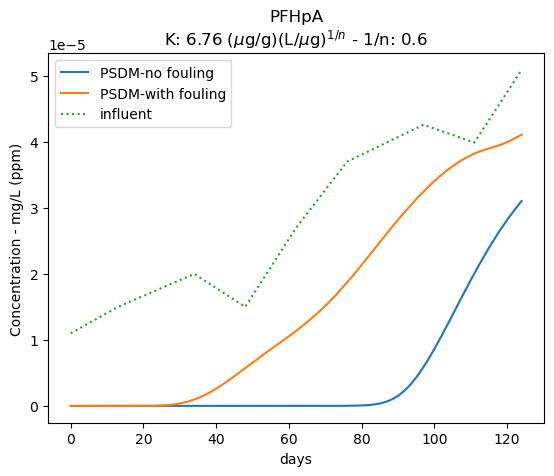

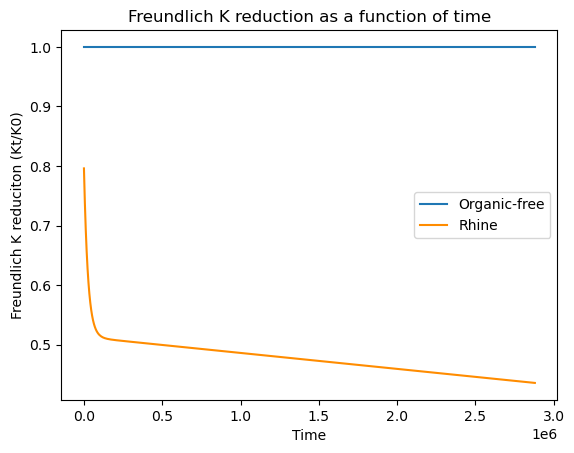

In [4]:
chem_type = 'PFAS'   #//Mathieu: according to article
water_type = 'Rhine' #//Mathieu: according to article
#note additional inputs in definition of column, below.

for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    print('EBCT: ', round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    column2 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type,
                   water_type=water_type,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-no fouling')
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-with fouling')
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    plt.figure()
    plt.plot(column.K_time, 
             column.K_new_time,
             label='Organic-free')
    plt.plot(column2.K_time, 
             column2.K_new_time,
             label='Rhine',
             color='darkorange')    
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)  # Enable grid
    plt.show()  # Display the plot    
    
    tab2 = 'model-'+comp
    
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example2.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)



//Mathieu: it can be seen that exactly the same output is generated as in section 6.4. Compound specific parameters b1 and b2 were calculated however. This can be seen from the fact that they are not rounded

In [5]:
chem_data.loc['α']

PFHpA    13.83
Name: α, dtype: float64